In [1]:
# Import relevant modules
import math
import numpy as np
import random as random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas as pd
from scipy.stats import gaussian_kde as kde
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import csv
import os
import glob
import warnings
import tarfile
warnings.filterwarnings("ignore")

plotly_display = False

mainDir = os.getcwd()
print(mainDir)

C:\Users\eilyness


In [2]:
# Load data from tar files
dataDir = mainDir + "/data/"
os.chdir(dataDir)

tarfiles = ['ngims_calibrated_2014.tar.gz', 'ngims_calibrated_2024.tar.gz', 
            'ngims_derivedL2_2014.tar.gz', 'ngims_derivedL2_2018.tar.gz', 'ngims_derivedL2_2024.tar.gz']
dataframes = [None] * 9

# Function to check if file contains data
def isValidFile(filename):
    isValidFile = False
    if not (filename.endswith('.csv')):
        return isValidFile
    validtypes = ['osion', 'osnb', 'ion-abund', 'csn-abund', 'raw-sci']
    for type in validtypes:
        if type in filename:
            isValidFile = True
    return isValidFile

for i in range(len(tarfiles)):
    print("Loading file {}".format(i+1))
    cur_tarfile = tarfiles[i]
    with tarfile.open(cur_tarfile, "r:*") as tar:
            if '2014' in cur_tarfile:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2014/10' in n)))
            elif '2018' in cur_tarfile:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2018/06' in n)))
            else:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2024/01' in n)))
            for j in range(len(csv_paths)):
                path = csv_paths[j]
                data = pd.read_csv(tar.extractfile(path))
                dataframes[i] = pd.concat([dataframes[i], data], axis=0, ignore_index=True)
                print("{0:.2f}%".format(100 * (j+1) / len(csv_paths)), end='\r')

Loading file 1
Loading file 2
Loading file 3
Loading file 4
Loading file 5


In [3]:
# Load data from csv files (already unpacked)
dataDir1a_2014 = dataDir + "/NGIMSl1a_10-14/"
dataDir1a_2018 = dataDir + "/NGIMSl1a_06-18/"
dataDir1a_2024 = dataDir + "/NGIMSl1a_01-24/"
dataDir1b_2018 = dataDir + "/NGIMSl1b_06-18/"
dataDirs = [dataDir1a_2014, dataDir1a_2018, dataDir1a_2024, dataDir1b_2018]

for i in range(4):
    os.chdir(dataDirs[i])
    csv_files = list((n for n in os.listdir() if isValidFile(n)))
    for j in range(len(csv_files)):
        file = csv_files[j]
        data = pd.read_csv(file)
        dataframes[i+5] = pd.concat([dataframes[i+5], data], axis=0, ignore_index=True)
        print("{0:.2f}%".format(100 * (j+1) / len(csv_files)), end='\r')

In [4]:
# Clean up and organize data

# Create relevant data frames
L1a_df = pd.concat([dataframes[5], dataframes[6], dataframes[7]], axis=0, ignore_index=True)
L1b_df = pd.concat([dataframes[0], dataframes[8], dataframes[1]], axis=0, ignore_index=True)
L2_df = pd.concat([dataframes[2], dataframes[3], dataframes[4]], axis=0, ignore_index=True)

# Function to find year of data from spacecraft time
def find_year(t):
    if t < 5 * (10**8):
        return '2014'
    elif t > 7 * (10**8):
        return '2024'
    else:
        return '2018'

# Create joint time and mass variables for csn and osion data
L2_df["t_sclk_combined"] = L2_df["t_sclk"].fillna(0) + L2_df["t_sclk_cor"].fillna(0)
L2_df["mass_combined"] = L2_df["ion_mass"].fillna(0) + L2_df["mass"].fillna(0)

# Create year categorical variable for each dataframe
L1a_df["year"] = L1a_df["TIME"].apply(find_year)
L1b_df["year"] = L1b_df["t_sclk_cor"].apply(find_year)
L2_df["year"] = L2_df["t_sclk_combined"].apply(find_year)

# Convert dates to datetime type
L1b_df["t_utc"] = pd.to_datetime(L1b_df["t_utc"])
L2_df["t_utc"] = pd.to_datetime(L2_df["t_utc"])

In [5]:
# Investigate abundance values
L2_df['abundance'].sort_values()[-770:-730]

3178906    4.675460e+10
5043307    4.155777e+12
3641518    4.256280e+12
4584226    3.428829e+13
5921678    8.448002e+14
5502686    6.721848e+18
3638489    9.215417e+18
3635714    7.192359e+19
3635434    8.731672e+19
5918700    1.879764e+20
4583860    5.717269e+20
2674392    3.978205e+22
6491896    1.041243e+27
6488909    8.634423e+27
6488771    9.396547e+27
6490898    9.646859e+27
6488176    1.335992e+28
6490424    1.360022e+28
6487783    1.667606e+28
5042609    1.787466e+28
4580668    2.120459e+28
4579759    3.860403e+28
4579331    5.022876e+28
7186685    5.065696e+28
4578219    9.452376e+28
4040407    1.831309e+31
5042360    4.187747e+34
4040597    1.797554e+35
3176532    2.889524e+36
5041773    5.481122e+41
5041678    1.007046e+42
2675258    8.634055e+42
1303564             inf
1303573             inf
1303574             inf
1303575             inf
2264585             inf
2264586             inf
2264588             inf
1213683             inf
Name: abundance, dtype: float64

In [6]:
# Look at interesting characteristics for super high abundance levels, we can see that
# all entries are from Argon in csn mode with cps registered as infinity for many of them
test_df = L2_df[L2_df['abundance'] > 10**11].loc[:,['abundance', 'species', 'focusmode', 'quality', 'precision', 'cps_dt_bkd', 'tid']]
for feature in ['species', 'focusmode', 'quality', 'tid']:
    print(test_df[feature].unique())
test_df.head(15)

['Ar']
['csn']
['IV' 'OV' 'IU']
[27954 27832 27846 28094 28090 27906 27842 27800 28096 27830 27862 27956
 27934 27940 27790 27856 27916 27818 28072 27966 27816 27894 27810 27974
 27920 28056 28042 27812 27976 28062 27928 27930 28054 27892 28050 27820
 28048 27964 28088 28034 28070 27908 54214 54310 54220 54218 54316 54314
 54216 54222 54308 54312]


abundance species focusmode quality  precision  cps_dt_bkd    tid
373677        inf      Ar       csn      IV        0.0         inf  27954
373678        inf      Ar       csn      IV        0.0         inf  27954
373679        inf      Ar       csn      IV        0.0         inf  27954
373680        inf      Ar       csn      IV        0.0         inf  27954
373681        inf      Ar       csn      IV        0.0         inf  27954
373682        inf      Ar       csn      IV        0.0         inf  27954
373683        inf      Ar       csn      IV        0.0         inf  27954
373684        inf      Ar       csn      IV        0.0         inf  27954
373685        inf      Ar       csn      IV        0.0         inf  27954
373686        inf      Ar       csn      IV        0.0         inf  27954
373687        inf      Ar       csn      IV        0.0         inf  27954
373688        inf      Ar       csn      IV        0.0         inf  27954
373689        inf      Ar       csn      IV        0.0         inf  27954
373690        inf      Ar       csn      IV        0.0         inf  27954
373691        inf      Ar       csn      IV        0.0         inf  27954

In [7]:
L2_df = L2_df[L2_df["abundance"] < 10**11].reset_index(drop=True)

# Create separate dataframes for csn and osion, remove variables that don't apply
L2_osion_df = L2_df[L2_df["focusmode"] == 'osion'].drop(["mass", "species", "cps_dt_bkd", 
                                                         "t_sclk_cor", "t_sclk_combined", "mass_combined"], axis=1)
L2_csn_df = L2_df[L2_df["focusmode"] == 'csn'].drop(["ion_mass", "cps_dt", "sensitivity", "SC_potential", 
                                                     "t_sclk", "t_sclk_combined", "mass_combined"], axis=1)

# Convert ram1 and ram2_rot_angle from level 1b to numbers
L1b_df = L1b_df.loc[pd.to_numeric(L1b_df["ram1"], errors='coerce').notna()]

L1a_df["MKID"] = L1a_df["MKID"].astype(int)
L1b_df["ram1"] = L1b_df["ram1"].astype(float)
L1b_df["ram2_rot_angle"] = L1b_df["ram2_rot_angle"].astype(float)

L1b_df[L1b_df['cps_dt'].isnull()].loc[:,['focus_mode', 'cps_dt', 'cps_dt_bkgd', 'cps_raw', 'counts', 'bkgd', 'mass']].head(20)

In [ ]:
print(np.sort(L1b_df[L1b_df['cps_dt'].isnull()]['tid'].unique()))
L1b_df = L1b_df[L1b_df['cps_dt'].notnull()].reset_index(drop=True)

In [8]:
# Go into folder to place plots
plotsDir = mainDir + "/plots/"
os.chdir(plotsDir)

In [ ]:
years = ['2014', '2018', '2024']
fig = sp.make_subplots(rows=1, 
                       cols=5, 
                       subplot_titles=['2014', '', '2018', '', '2024'], 
                       column_widths=[2.5, 0.3, 2.5, 0.3, 2.5],
                       shared_yaxes=True)

for year, i in zip(years, range(3)):
    fig.add_trace(go.Scatter(
        x=L1b_df[L1b_df['cps_dt'].isnull() & (L1b_df['year'] == year)]['t_utc'].unique(),
        y=L1b_df[L1b_df['cps_dt'].isnull() & (L1b_df['year'] == year)]['mass'],
        mode='markers',
        marker={'size': 4},
        marker_color='blue',
        name='Level 1b'), row=1, col=2*i+1)
    
    fig.add_trace(go.Scatter(
        x=L1b_df[L1b_df['cps_dt'].isnull() & (L1b_df['year'] == year)]['t_utc'].unique(),
        y=L2_df[L2_df['t_utc'].isin(L1b_df[L1b_df['cps_dt'].isnull()]['t_utc']) & (L2_df['year'] == year)]['mass_combined'],
        mode='markers',
        marker={'size': 4},
        marker_color='orange',
        name='Level 2'), row=1, col=2*i+1)
        
fig.update_layout(
    title="level 1b cps vs level 2 cps for null calibrated cps values",
    xaxis_title='time',
    yaxis_title='mass',
    width=800,
    height=800)

fig.write_html('l1b_mass_vs_l2_mass(by_year).html')

print(L2_df[L2_df['t_utc'].isin(L1b_df[L1b_df['cps_dt'].isnull()]['t_utc'])]['focusmode'].unique())
print(L1b_df[L1b_df['cps_dt'].isnull()]['focus_mode'].unique())

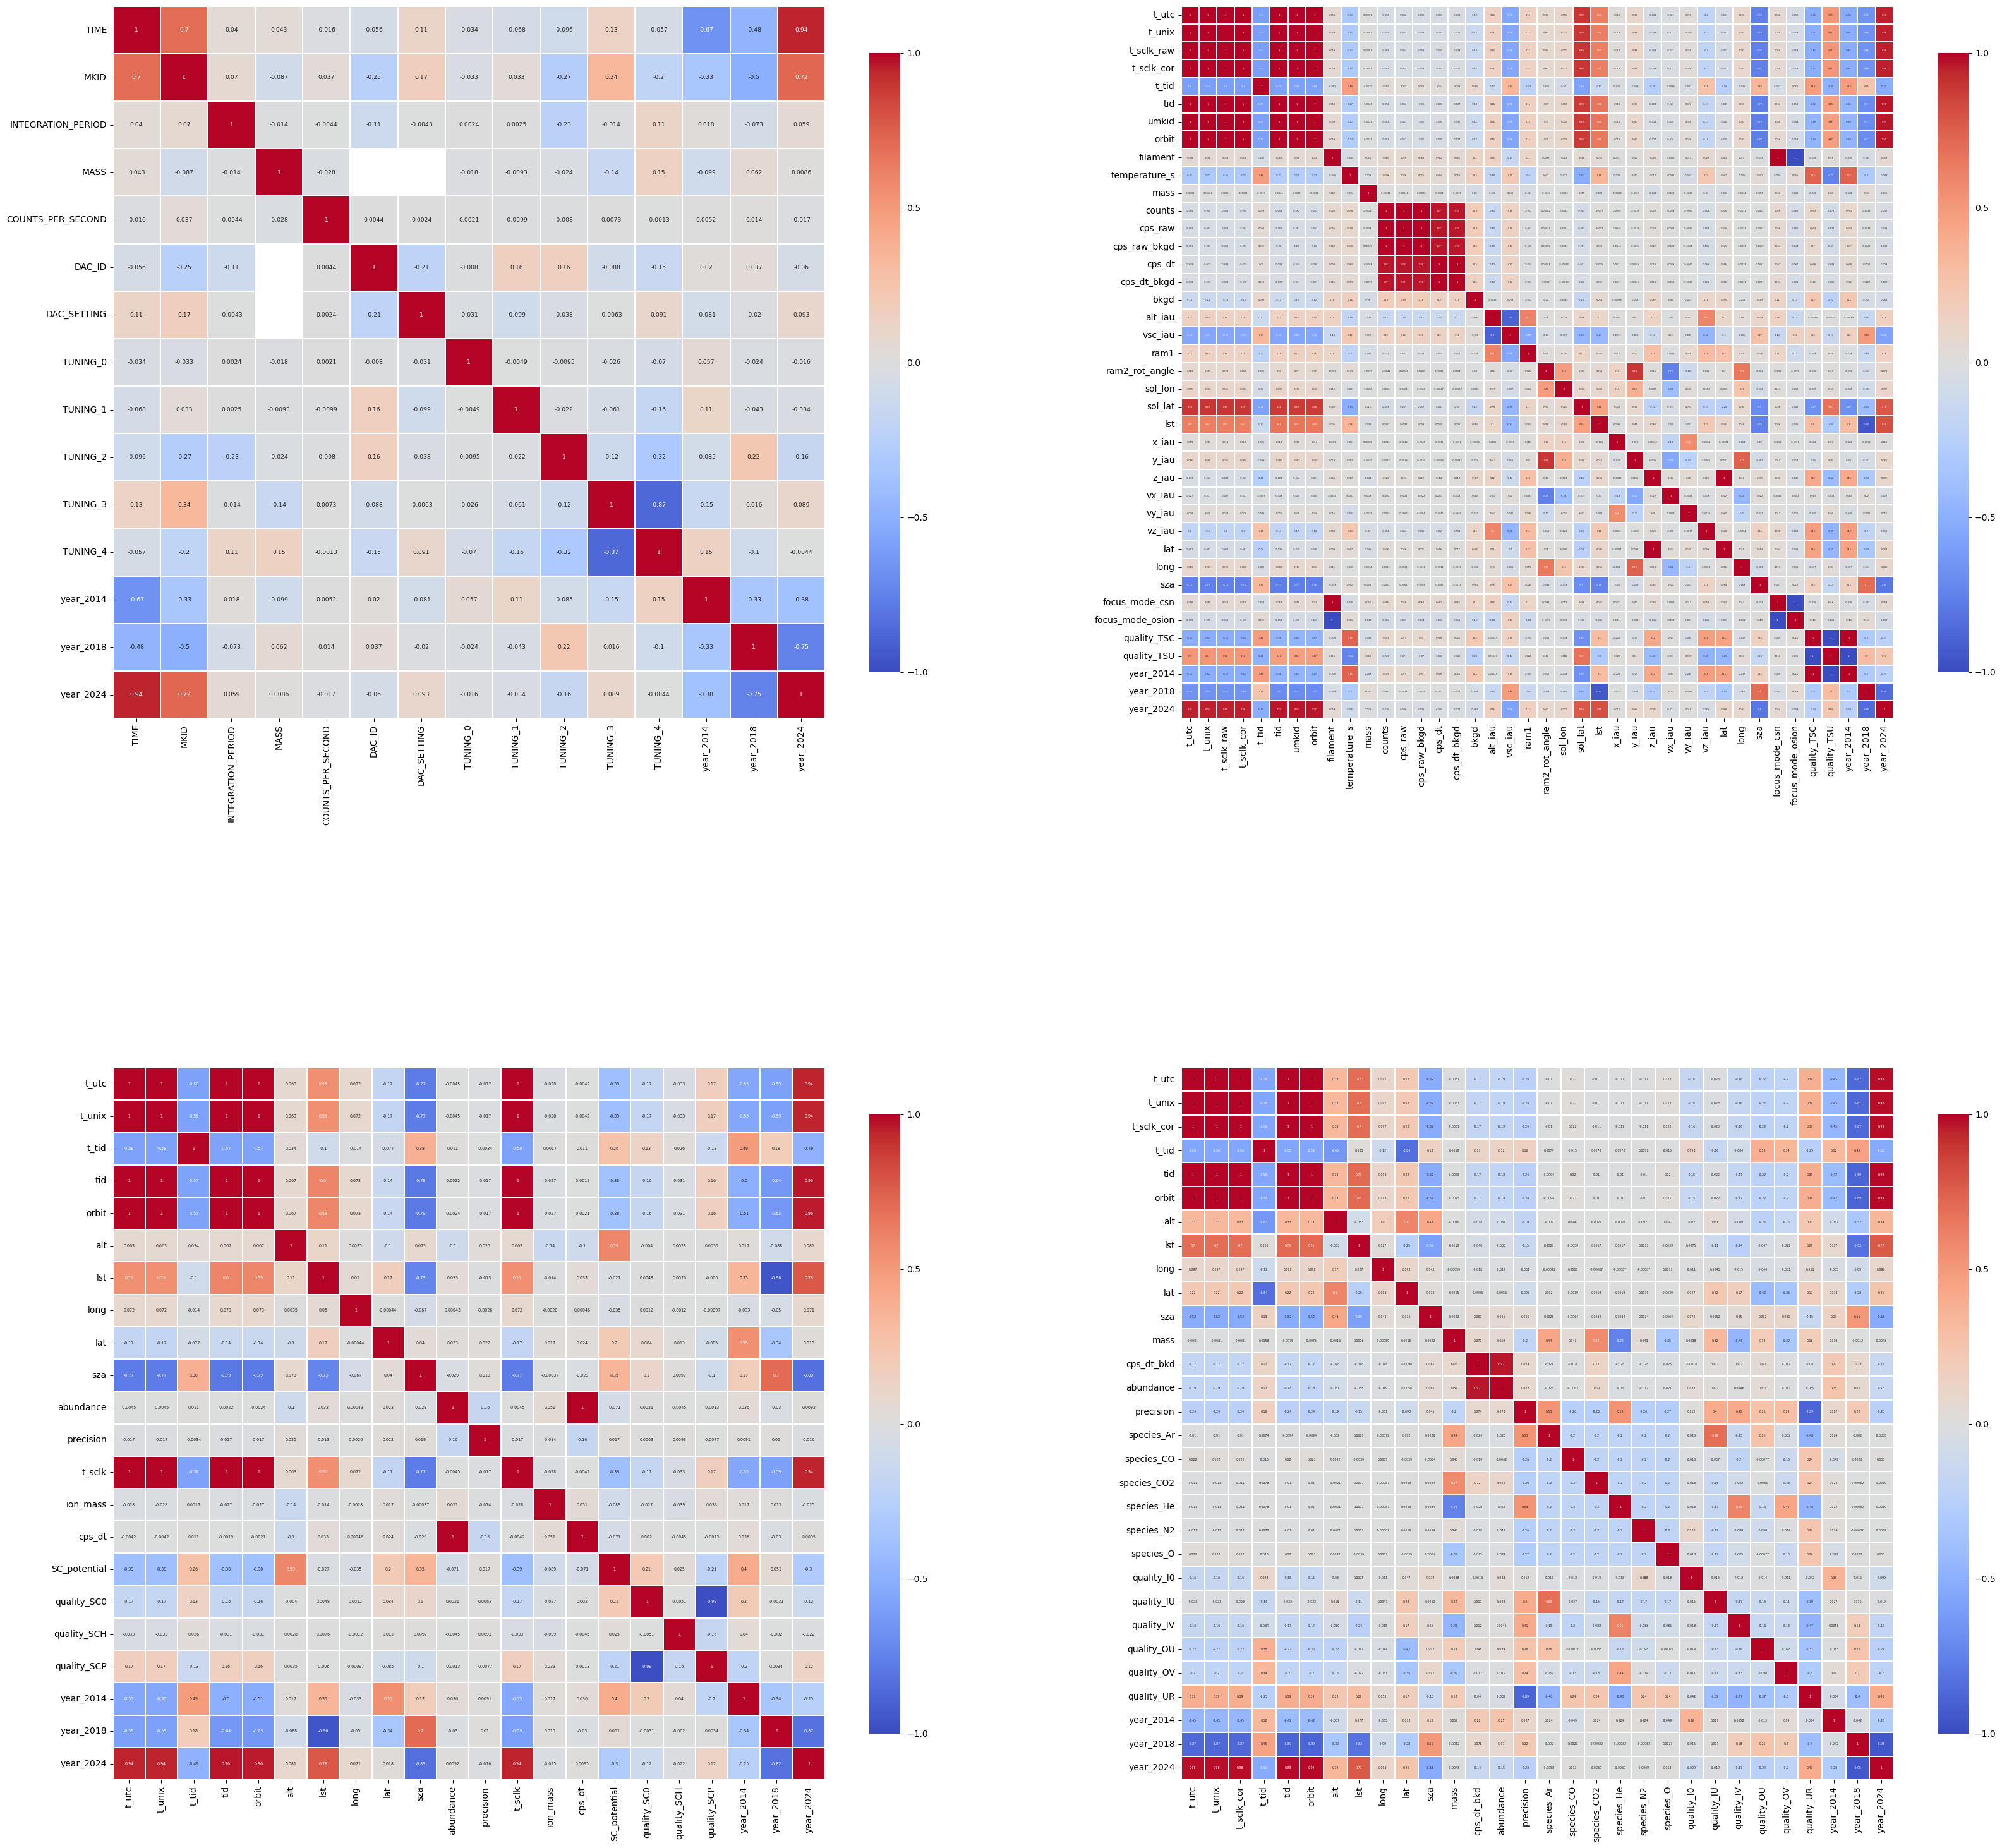

In [9]:
# Make heatmaps for each level of data

# Create filtered dataframes with dummies for categoricals and only interesting features
L1a_df_nums = pd.get_dummies(L1a_df)
L1b_df_nums = pd.get_dummies(L1b_df.drop("multiplier", axis=1))
L2_osion_df_nums = pd.get_dummies(L2_osion_df.drop(["focusmode", "sensitivity"], axis=1))
L2_csn_df_nums = pd.get_dummies(L2_csn_df.drop("focusmode", axis=1))

df_corrs = [L1a_df_nums, L1b_df_nums, L2_osion_df_nums, L2_csn_df_nums]

fig, axs = plt.subplots(2, 2, figsize=(40,40))

for i in range(4):
    sns.heatmap(df_corrs[i].corr(),
        ax = axs.flatten()[i],
        square = True,
        linewidths = .3,
        cmap = 'coolwarm',
        cbar_kws = {'shrink': .7, 
                    'ticks' : [-1, -.5, 0, 0.5, 1]},
        vmin = -1, 
        vmax = 1,
        annot = True,
        annot_kws = {"size": 100 / len(df_corrs[i].columns)})

plt.savefig("NGIMS_heatmaps.png")

In [10]:
years = L2_df["year"].unique()
L1a_sample_data = None
L1b_sample_data = None
L2_sample_data = None
L2_osion_sample_data = None
L2_csn_sample_data = None

random_state = 2522350
for year in years:
    L1a_sample_data = pd.concat([L1a_sample_data, L1a_df[L1a_df["year"] == year].sample(50000, random_state=random_state)], 
                                axis=0, ignore_index=True)
    L1b_sample_data = pd.concat([L1b_sample_data, L1b_df[L1b_df["year"] == year].sample(50000, random_state=random_state)], 
                                axis=0, ignore_index=True)
    L2_sample_data = pd.concat([L2_sample_data, L2_df[L2_df["year"] == year].sample(50000, random_state=random_state)], 
                                axis=0, ignore_index=True)
    L2_osion_sample_data = pd.concat([L2_osion_sample_data, L2_osion_df[L2_osion_df["year"] == year].sample(50000, random_state=random_state)], 
                                     axis=0, ignore_index=True)
    L2_csn_sample_data = pd.concat([L2_csn_sample_data, L2_csn_df[L2_csn_df["year"] == year].sample(50000, random_state=random_state)], 
                                   axis=0, ignore_index=True)

L1a_sample_data = L1a_sample_data.sample(frac=1).reset_index(drop=True)
L1b_sample_data = L1b_sample_data.sample(frac=1).reset_index(drop=True)
L2_sample_data = L2_sample_data.sample(frac=1).reset_index(drop=True)
L2_osion_sample_data = L2_osion_sample_data.sample(frac=1).reset_index(drop=True)
L2_csn_sample_data = L2_csn_sample_data.sample(frac=1).reset_index(drop=True)

L2_sample_data.info()
L2_sample_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   t_utc            150000 non-null  datetime64[ns]
 1   t_unix           150000 non-null  float64       
 2   t_sclk_cor       58394 non-null   float64       
 3   t_tid            150000 non-null  float64       
 4   tid              150000 non-null  int64         
 5   orbit            150000 non-null  int64         
 6   focusmode        150000 non-null  object        
 7   alt              150000 non-null  float64       
 8   lst              150000 non-null  float64       
 9   long             150000 non-null  float64       
 10  lat              150000 non-null  float64       
 11  sza              150000 non-null  float64       
 12  mass             58394 non-null   float64       
 13  species          58394 non-null   object        
 14  cps_dt_bkd       583

t_utc        t_unix    t_sclk_cor        t_tid    tid  orbit  \
0 2014-10-20 05:12:44  1.413782e+09           NaN  5377.363249  14025    117   
1 2024-01-13 12:53:11  1.705150e+09           NaN  4912.479642  54292  20396   
2 2024-01-08 01:17:36  1.704677e+09  7.579483e+08  3607.477619  54220  20360   
3 2018-06-12 13:46:28  1.528811e+09  5.820831e+08  5439.034388  27910   7205   
4 2024-01-07 17:53:33  1.704650e+09  7.579217e+08  3209.506779  54216  20358   

  focusmode        alt        lst       long  ...   precision  quality  \
0     osion   187.7715  14.639720  -41.99715  ...    0.034262      SCP   
1     osion   269.8482  13.804170  -88.88285  ...    0.007233      SCP   
2       csn   701.3152  12.723610   16.07325  ... -999.000000       UR   
3       csn   164.8226   7.555305  -54.67857  ...    0.000090       OU   
4       csn  1104.4270  11.692780  108.65820  ...    0.000000       IV   

         t_sclk ion_mass        cps_dt  sensitivity  SC_potential  \
0  4.670539e+08     14.0    851.869745        550.0     -0.850898   
1  7.584221e+08     30.0  19111.960548        550.0     -1.942194   
2           NaN      NaN           NaN          NaN           NaN   
3           NaN      NaN           NaN          NaN           NaN   
4           NaN      NaN           NaN          NaN           NaN   

  t_sclk_combined  mass_combined  year  
0    4.670539e+08           14.0  2014  
1    7.584221e+08           30.0  2024  
2    7.579483e+08           28.0  2024  
3    5.820831e+08           44.0  2018  
4    7.579217e+08            4.0  2024  

[5 rows x 26 columns]

<Figure size 4000x4000 with 0 Axes>

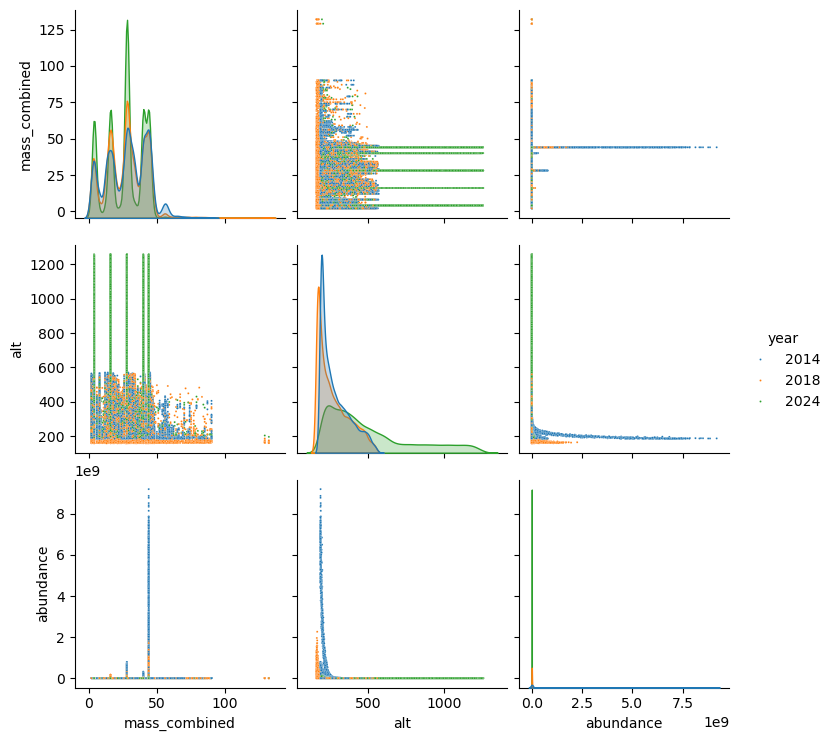

In [11]:
plt.figure(figsize=(40,40))
sns.pairplot(L2_sample_data, 
             vars=["mass_combined", "alt", "abundance"], 
             hue='year',
             hue_order=['2014', '2018', '2024'],
             palette=sns.color_palette("tab10"),
             diag_kind='kde', 
             plot_kws={"s": 2})
plt.savefig("L2_pairplots.png")

<Figure size 4000x4000 with 0 Axes>

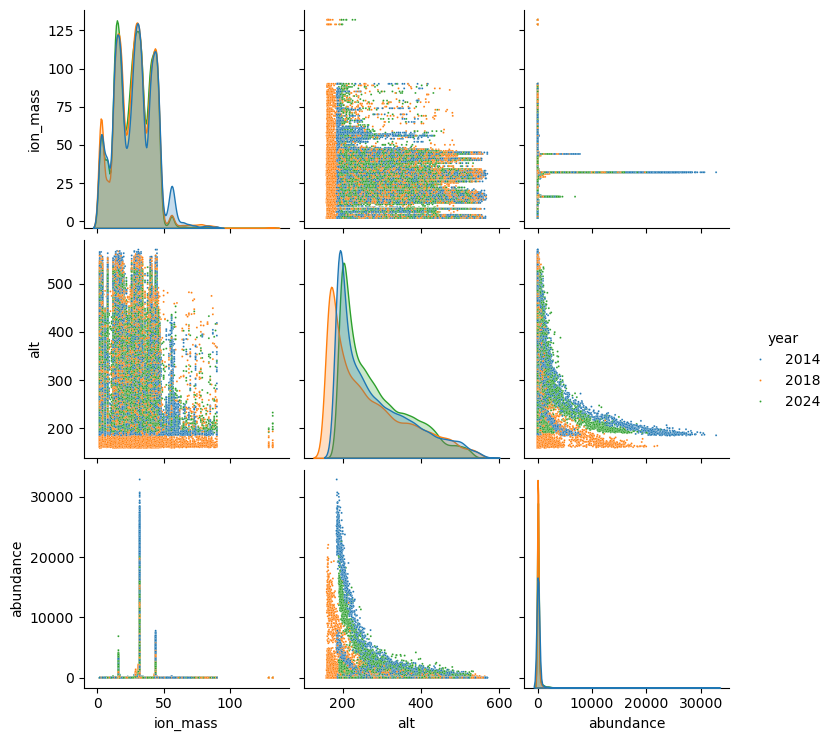

In [12]:
plt.figure(figsize=(40,40))
sns.pairplot(L2_osion_sample_data, 
             vars=["ion_mass", "alt", "abundance"], 
             hue='year',
             hue_order=['2014', '2018', '2024'],
             palette=sns.color_palette("tab10"),
             diag_kind='kde', 
             plot_kws={"s": 2})
plt.savefig("L2_osion_pairplots.png")

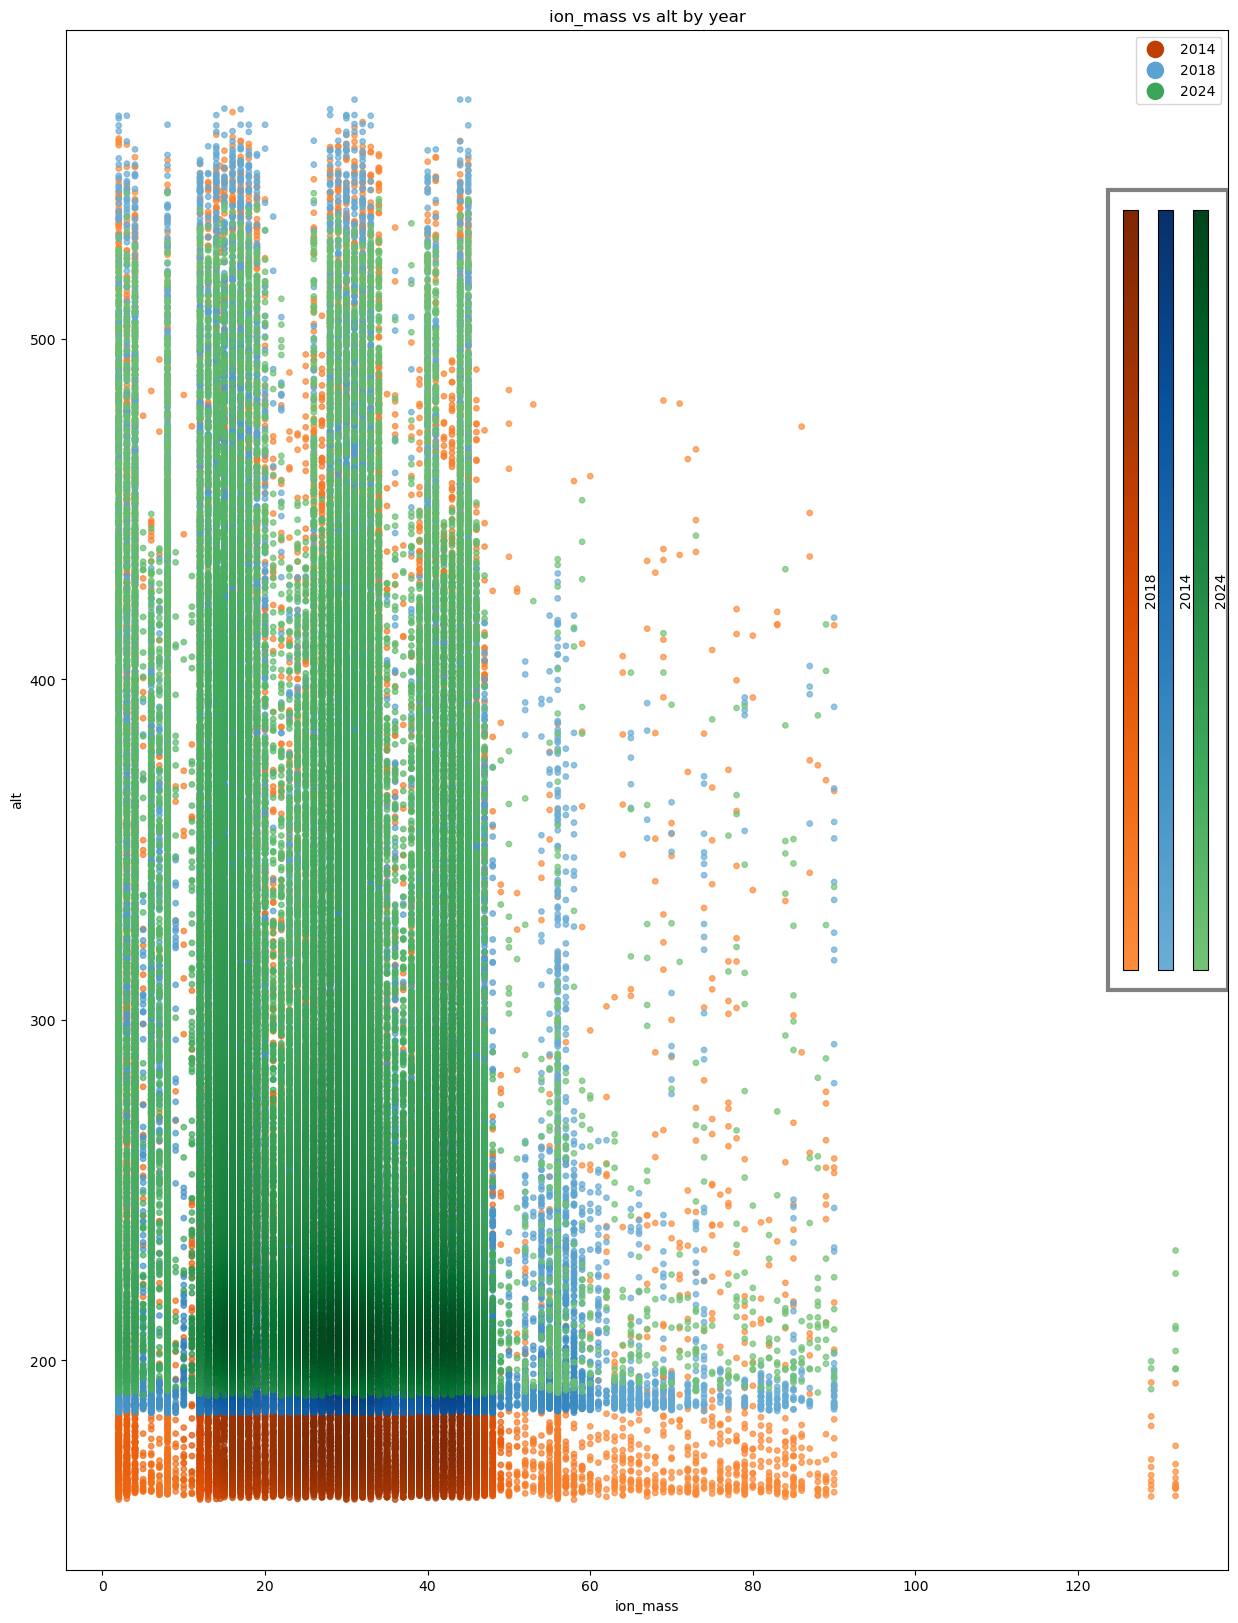

<Figure size 640x480 with 0 Axes>

In [13]:
def makeColors(vals, colormap):
    density_colors = np.zeros((len(vals), 3))
    norm = Normalize(vmin=vals.min(), vmax=vals.max())
    density_colors = [cm.ScalarMappable(norm=norm, cmap=colormap).to_rgba(val) for val in vals]
    return density_colors, norm

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def densityScatter(DataFrame, feature1, feature2, label):
    label_pts = []
    categories = DataFrame[label].unique()
    for category in categories:
        label_pts.append(DataFrame[DataFrame[label] == category].loc[:,[feature1, feature2]].transpose())

    cmaps = ['Oranges', 'Blues', 'Greens', 'Reds', 'Purples']
    handles = [None] * len(label_pts)

    fig, ax = plt.subplots(1, figsize=(15,20))
    plt.title("{} vs {} by {}".format(feature1, feature2, label))
    plt.xlabel("{}".format(feature1))
    plt.ylabel("{}".format(feature2))
    inv = ax.transData.inverted()
    plt.gca().add_patch(Rectangle((0.82,0.4), 
                                      0.08, 
                                      0.4, 
                                      edgecolor='gray',
                                      linewidth=3, 
                                      fill=False,
                                      transform=fig.transFigure))

    for label_data, cmap, category, i in zip(label_pts, cmaps, categories, range(len(label_pts))):
        densObj = kde(label_data)
        cmap = truncate_colormap(plt.get_cmap(cmap), 0.5, 1.0)
        density_colors, norm = makeColors(densObj.evaluate(label_data), cmap)
        handles[i] = ax.scatter(x=feature1,
                                y=feature2,
                                data=DataFrame[DataFrame[label] == category],
                                color=density_colors,
                                alpha=0.7,
                                s=15)
        cax = fig.add_axes([0.83 + i*(0.07 / len(label_pts)), 0.41, 0.03 / len(label_pts), 0.38]) 
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
        cbar.set_ticks([])
        cbar.set_label(category)

    leg = ax.legend(handles, years, loc='upper right', markerscale=3)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.show()
    plt.savefig('{}vs{}_by_{}.png'.format(feature1, feature2, label))

densityScatter(L2_osion_sample_data, 'ion_mass', 'alt', 'year')

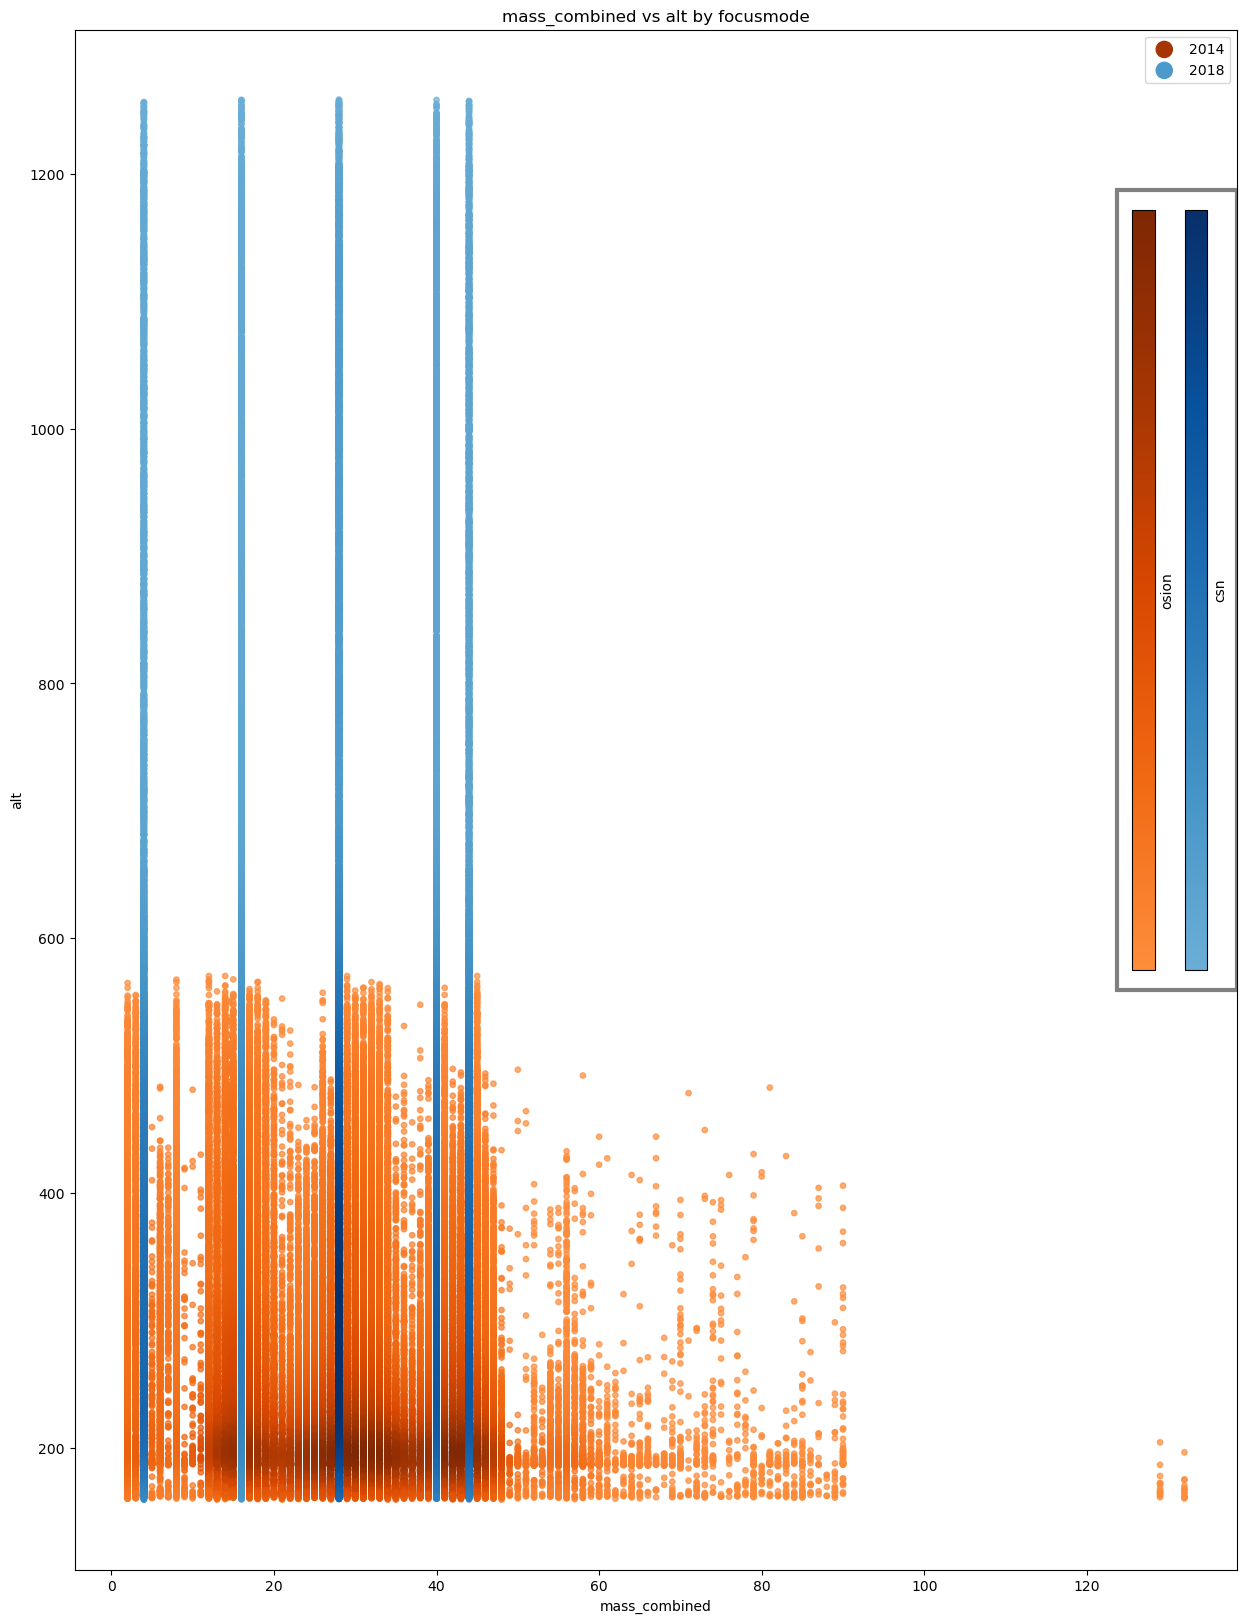

<Figure size 640x480 with 0 Axes>

In [30]:
densityScatter(L2_sample_data, 'mass_combined', 'alt', 'focusmode')

In [32]:
def overlayScatter(DataFrame, feature1, feature2, label):
    categories = DataFrame[label].unique()
    marker_colors = ['orange', 'blue', 'green', 'red', 'purple']
    
    fig = go.Figure()
    for category, marker_color in zip(categories, marker_colors):
        fig.add_trace(go.Scatter(
            x=DataFrame[DataFrame[label] == category][feature1],
            y=DataFrame[DataFrame[label] == category][feature2],
            mode='markers',
            marker={'size': 4},
            name=category,
            marker_color=marker_color))

    fig.update_layout(
        title="{} vs {} by {}".format(feature1, feature2, label),
        xaxis_title=feature1,
        yaxis_title=feature2,
        width=800,
        height=800)

    if plotly_display == True:
        fig.show()
        
    fig.write_html('{}vs{}by_{}_plotly_color_scatter.html'.format(feature1, feature2, label))

overlayScatter(L2_osion_sample_data, "ion_mass", "alt", "year")
overlayScatter(L2_sample_data, "mass_combined", "alt", "focusmode")

In [222]:
def byYearScatter(DataFrame, feature1, feature2, label=None):
    years = ['2014', '2018', '2024']
    marker_colors = ['orange', 'blue', 'green', 'red', 'purple']
    if label != None:
        categories = DataFrame[label].unique()
    fig = sp.make_subplots(rows=1, 
                           cols=5, 
                           subplot_titles=['2014', '', '2018', '', '2024'], 
                           column_widths=[2.5, 0.3, 2.5, 0.3, 2.5],
                           shared_yaxes=True)
    for year, marker_color, i in zip(years, marker_colors, range(3)):
        if label == None:
            fig.add_trace(go.Scatter(
                x=DataFrame[DataFrame['year'] == year][feature1],
                y=DataFrame[DataFrame['year'] == year][feature2],
                mode='markers',
                marker={'size': 4},
                marker_color=marker_color,), row=1, col=2*i+1)
        else:
            for category, marker_color in zip(categories, marker_colors):
                fig.add_trace(go.Scatter(
                x=DataFrame[(DataFrame['year'] == year) & (DataFrame[label] == category)][feature1],
                y=DataFrame[(DataFrame['year'] == year) & (DataFrame[label] == category)][feature2],
                name='{}_{}'.format(category, year),
                mode='markers',
                marker={'size': 4},
                marker_color=marker_color,), row=1, col=2*i+1)
                
    fig.update_layout(
        title="{} vs {} by year".format(feature1, feature2),
        xaxis_title=feature1,
        yaxis_title=feature2,
        width=2000,
        height=800)

    if plotly_display == True:
        fig.show()

    if label == None:
        fig.write_html('{}vs{}by_year_plotly.html'.format(feature1, feature2))
    else:
        fig.write_html('{}vs{}by_year_and_{}_plotly.html'.format(feature1, feature2, label))
    
byYearScatter(L2_osion_sample_data, 't_utc', 'SC_potential')

In [36]:
byYearScatter(L2_sample_data, 't_utc', 'lst')

In [38]:
overlayScatter(L2_osion_sample_data, 'alt', 'SC_potential', 'year')

In [72]:
years = ['2014', '2018', '2024']
clrs = ['orange', 'blue', 'green']

fig = go.Figure()
for year, clr in zip(years, clrs):
    year_data = L2_sample_data[L2_sample_data['year'] == year]
    fig.add_trace(go.Histogram(
        x=year_data.groupby(["tid"])["t_tid"].max() - year_data.groupby(["tid"])["t_tid"].min(),
        name=year))

fig.update_layout(
    title="tid vs test time (s)",
    xaxis_title='test_time',
    yaxis_title='count',
    width=800,
    height=800)

if plotly_display == True:
    fig.show()
    
fig.write_html('test_times_hist_plotly.html')


In [74]:
L1b_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 37 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   t_utc           150000 non-null  datetime64[ns]
 1   t_unix          150000 non-null  float64       
 2   t_sclk_raw      150000 non-null  float64       
 3   t_sclk_cor      150000 non-null  float64       
 4   t_tid           150000 non-null  float64       
 5   tid             150000 non-null  int64         
 6   umkid           150000 non-null  int64         
 7   orbit           150000 non-null  int64         
 8   focus_mode      150000 non-null  object        
 9   multiplier      150000 non-null  int64         
 10  filament        150000 non-null  int64         
 11  temperature_s   150000 non-null  float64       
 12  mass            150000 non-null  float64       
 13  counts          150000 non-null  int64         
 14  cps_raw         150000 non-null  flo

<Figure size 4000x4000 with 0 Axes>

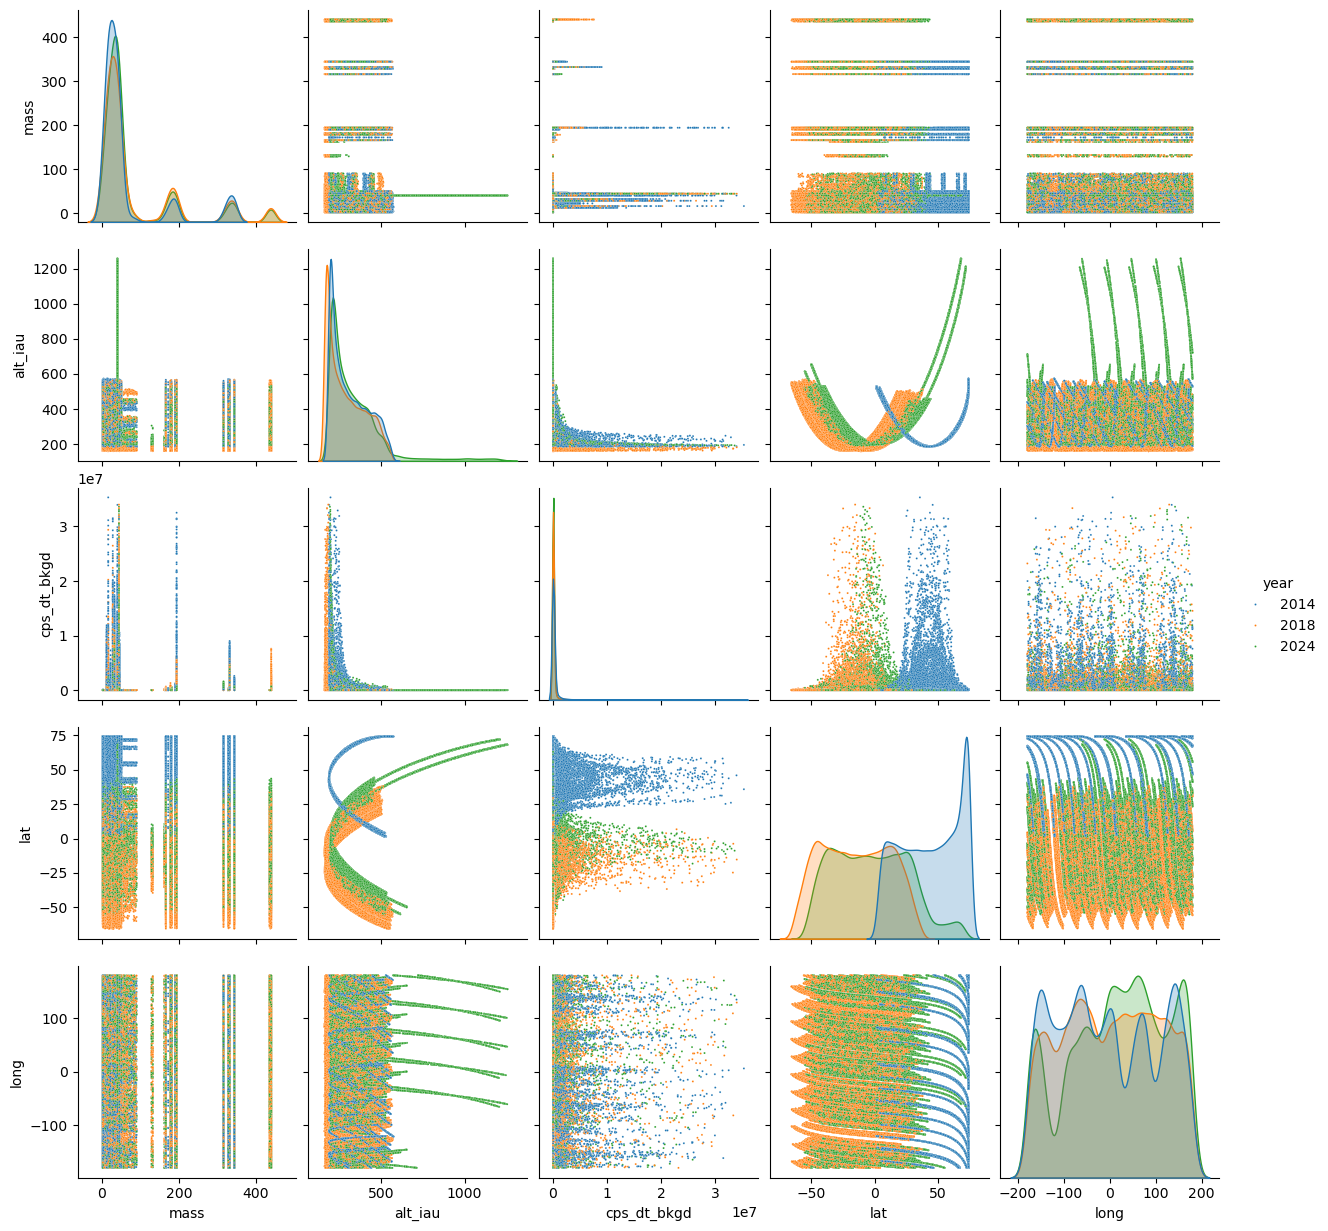

In [194]:
plt.figure(figsize=(40,40))
sns.pairplot(L1b_sample_data, 
             vars=["mass", "alt_iau", "cps_dt_bkgd", "lat", "long"], 
             hue='year',
             hue_order=['2014', '2018', '2024'],
             palette=sns.color_palette("tab10"),
             diag_kind='kde', 
             plot_kws={"s": 2})
plt.savefig("L1b_pairplots.png")

In [224]:
byYearScatter(L1b_sample_data, 't_utc', 'vsc_iau', label='focus_mode')
byYearScatter(L1b_sample_data, 't_utc', 'sol_lat', label='focus_mode')
byYearScatter(L1b_sample_data, 't_utc', 'sza', label='focus_mode')

In [228]:
L2_osion_sample_data['ion_mass'].describe()

count    150000.000000
mean         27.571183
std          14.208857
min           2.000000
25%          16.000000
50%          28.000000
75%          39.000000
max         132.000000
Name: ion_mass, dtype: float64

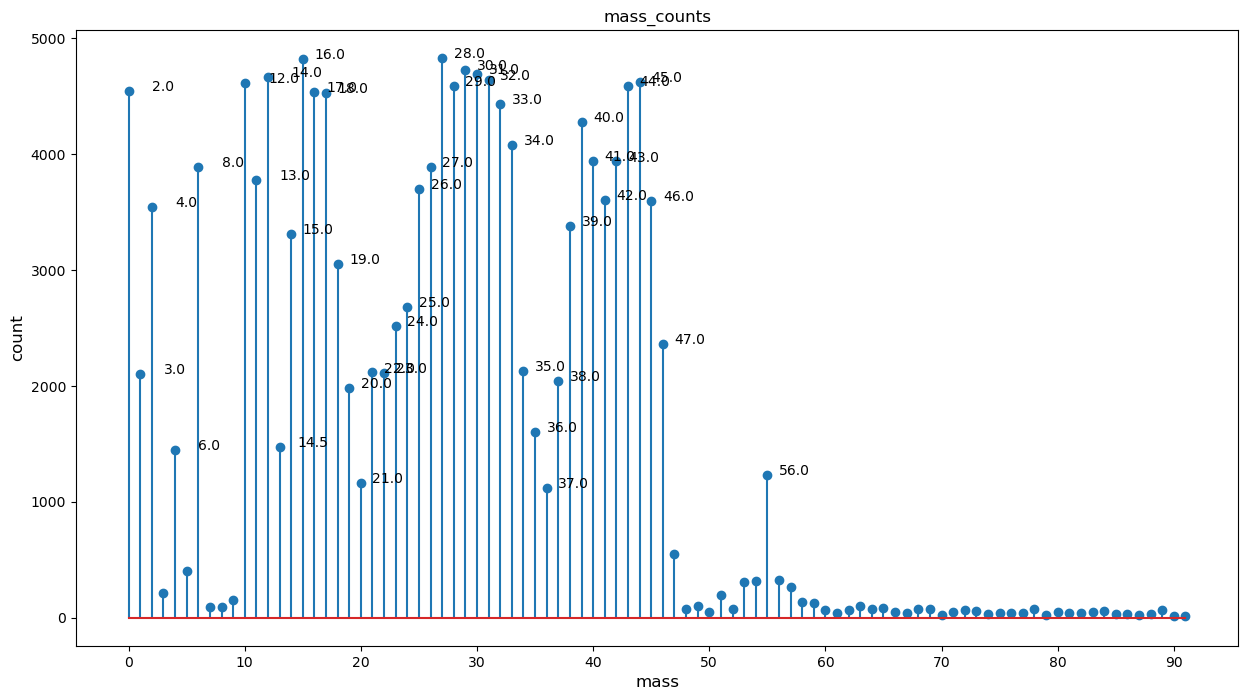

In [264]:
mass_count = pd.DataFrame({'count': L2_osion_sample_data.groupby('ion_mass').size()})

plt.figure(figsize=(15,8))
plt.stem(mass_count)
plt.xticks(np.arange(0, 100, step=10))
plt.xlabel('mass', fontsize = 12)
plt.ylabel('count', fontsize = 12)
plt.title("mass counts")
for x,y in zip(mass_count.index, mass_count['count']):
    if y>1000:
        label = "{:.1f}".format(float(x))
        plt.annotate(label, (x,y))
plt.show()
plt.savefig('mass_counts.png')

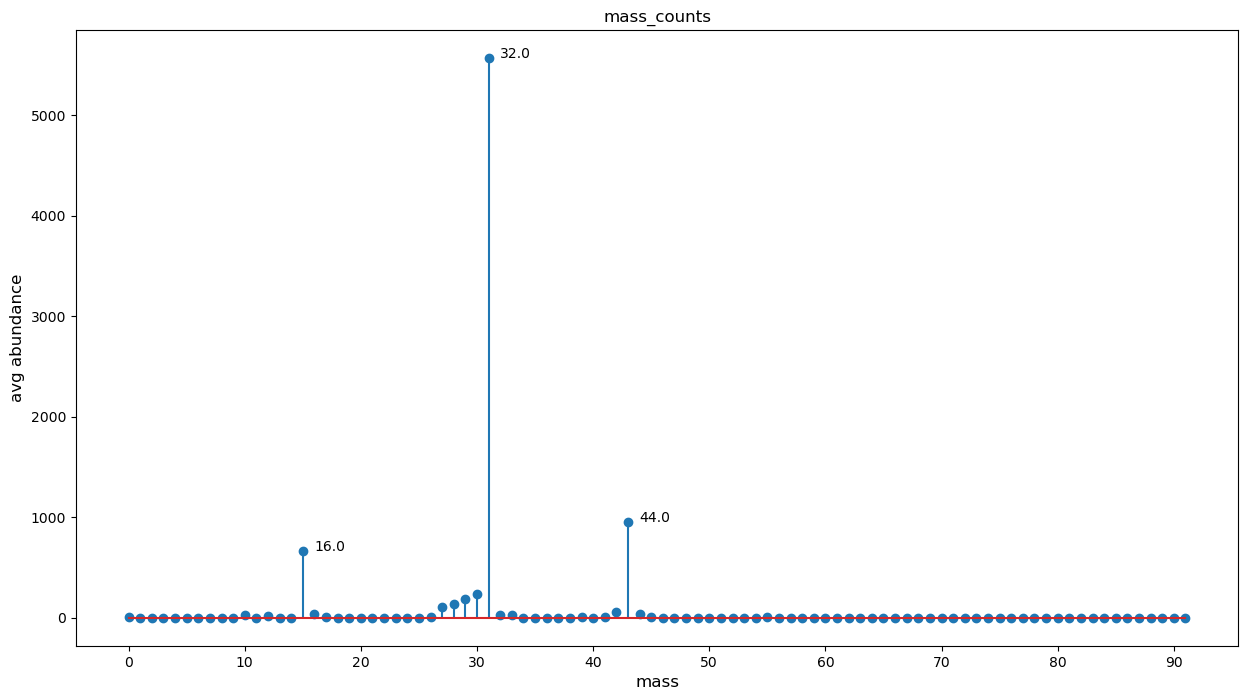

<Figure size 640x480 with 0 Axes>

In [278]:
mass_abundance = pd.DataFrame({'abundance': L2_osion_sample_data.groupby('ion_mass')['abundance'].mean()})

plt.figure(figsize=(15,8))
plt.stem(mass_abundance)
plt.xticks(np.arange(0, 100, step=10))
plt.xlabel('mass', fontsize = 12)
plt.ylabel('avg abundance', fontsize = 12)
plt.title("mass abundance")
for x,y in zip(mass_abundance.index, mass_abundance['abundance']):
    if y>500:
        label = "{:.1f}".format(float(x))
        plt.annotate(label, (x,y))
plt.show()
plt.savefig('mass_abundance.png')

In [280]:
L2_osion_sample_data[L2_osion_sample_data['ion_mass'] == 32]['abundance'].describe()

count     4643.000000
mean      5571.544382
std       6768.989113
min          0.067345
25%        519.310821
50%       2230.168945
75%       9335.081543
max      32839.218750
Name: abundance, dtype: float64

In [282]:
L2_osion_sample_data[L2_osion_sample_data['ion_mass'] == 44]['abundance'].describe()

count    4586.000000
mean      956.137609
std      1466.099325
min         0.047141
25%        21.633626
50%       177.711045
75%      1406.365387
max      7777.681152
Name: abundance, dtype: float64

In [288]:
L2_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   t_utc            150000 non-null  datetime64[ns]
 1   t_unix           150000 non-null  float64       
 2   t_sclk_cor       58394 non-null   float64       
 3   t_tid            150000 non-null  float64       
 4   tid              150000 non-null  int64         
 5   orbit            150000 non-null  int64         
 6   focusmode        150000 non-null  object        
 7   alt              150000 non-null  float64       
 8   lst              150000 non-null  float64       
 9   long             150000 non-null  float64       
 10  lat              150000 non-null  float64       
 11  sza              150000 non-null  float64       
 12  mass             58394 non-null   float64       
 13  species          58394 non-null   object        
 14  cps_dt_bkd       583

In [367]:
L2_sample_data_processed = L2_sample_data.drop(['t_utc', 't_sclk_cor', 'orbit', 'focusmode', 'mass', 'species', 
                                                'cps_dt_bkd', 'quality', 't_sclk', 'ion_mass', 'cps_dt', 
                                                'sensitivity', 'SC_potential', 't_sclk_combined', 'year'], axis=1)

def applyPCA(DataFrame, n=None):
    standardized_data = StandardScaler().fit_transform(DataFrame)
    standardized_data = pd.DataFrame(standardized_data, columns=DataFrame.columns)
    if n == None:
        pca_model = PCA()
    else:
        pca_model = PCA(n)
    pca = pca_model.fit_transform(standardized_data)

    return pca, pca_model

L2time_pca, L2time_pca_model = applyPCA(L2_sample_data_processed)

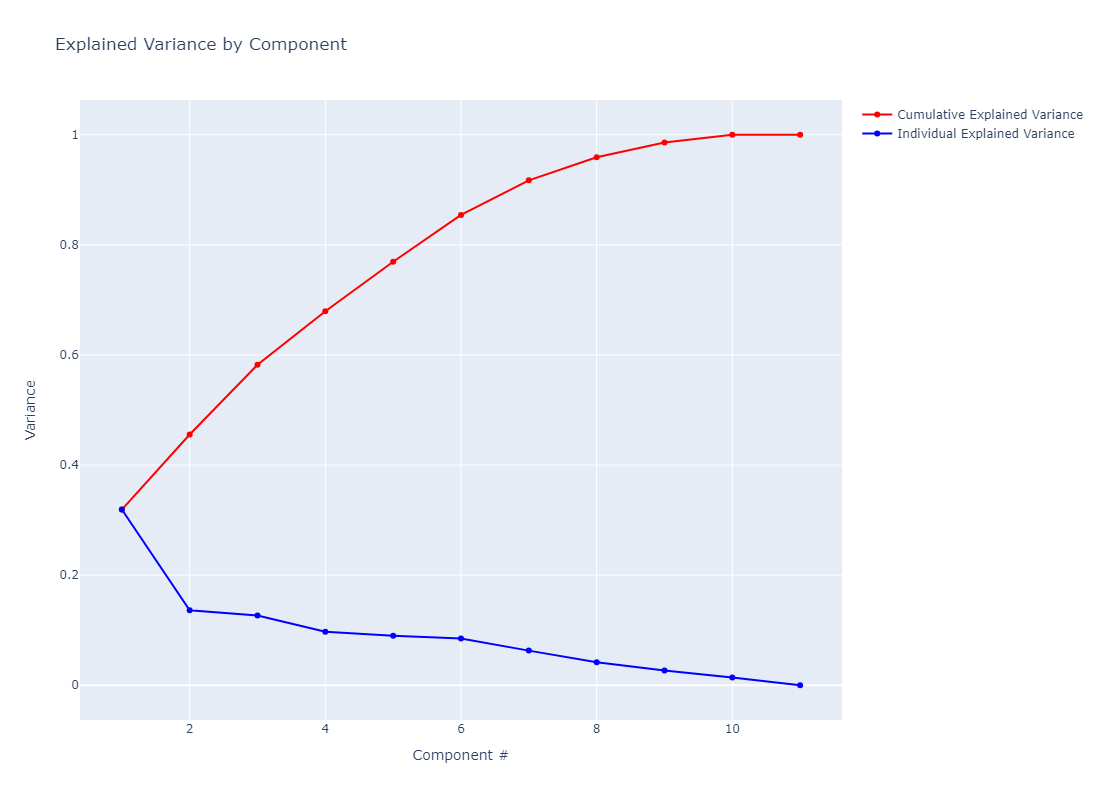

t_unix     t_tid       tid       alt       lst  \
Principal Component 1   0.508834  0.349691  0.511953  0.307516  0.063661   
Principal Component 2   0.144639  0.118190  0.104991  0.335265  0.566207   
Principal Component 3   0.035145  0.285589  0.053520  0.429516  0.538220   
Principal Component 4   0.016703  0.115708  0.009993  0.049395  0.120686   
Principal Component 5   0.001214  0.195539  0.003644  0.005478  0.051611   
Principal Component 6   0.038069  0.072223  0.036903  0.043818  0.039375   
Principal Component 7   0.023479  0.599729  0.030378  0.190298  0.014352   
Principal Component 8   0.175556  0.368364  0.177484  0.600122  0.041352   
Principal Component 9   0.308527  0.478604  0.299794  0.325458  0.414635   
Principal Component 10  0.296038  0.030301  0.323524  0.319178  0.437987   
Principal Component 11  0.709228  0.000222  0.703970  0.000410  0.035015   

                            long       lat       sza  abundance  precision  \
Principal Component 1   0.087535  0.079392  0.354050   0.051803   0.339910   
Principal Component 2   0.079457  0.672047  0.022524   0.100093   0.219727   
Principal Component 3   0.073206  0.251148  0.573023   0.109130   0.167664   
Principal Component 4   0.153226  0.036189  0.053259   0.600324   0.137933   
Principal Component 5   0.956851  0.124866  0.020429   0.096169   0.010892   
Principal Component 6   0.021780  0.022702  0.011691   0.775148   0.131088   
Principal Component 7   0.156548  0.378038  0.140450   0.067625   0.628313   
Principal Component 8   0.119466  0.134443  0.072748   0.014711   0.613285   
Principal Component 9   0.048072  0.545231  0.091720   0.001577   0.004963   
Principal Component 10  0.007654  0.055858  0.713403   0.010182   0.028676   
Principal Component 11  0.000062  0.013203  0.004659   0.000206   0.000206   

                        mass_combined  
Principal Component 1        0.023466  
Principal Component 2        0.065796  
Principal Component 3        0.058001  
Principal Component 4        0.749792  
Principal Component 5        0.134597  
Principal Component 6        0.607731  
Principal Component 7        0.126240  
Principal Component 8        0.161733  
Principal Component 9        0.000008  
Principal Component 10       0.004490  
Principal Component 11       0.000223

In [371]:
def PCA_Summary(pca_model, columns, name):

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=list(range(1,len(pca_model.explained_variance_ratio_ )+1)),
        y=np.cumsum(pca_model.explained_variance_ratio_),
        name='Cumulative Explained Variance',
        mode='lines+markers',
        marker_color='red'))
    
    fig.add_trace(go.Scatter(
        x=list(range(1,len(pca_model.explained_variance_ratio_ )+1)),
        y=pca_model.explained_variance_ratio_,
        name='Individual Explained Variance',
        mode='lines+markers',
        marker_color='blue'))
    
    fig.update_layout(
        title='Explained Variance by Component',
        xaxis_title='Component #',
        yaxis_title='Variance',
        width=800,
        height=800)
    
    fig.show()
    
    fig.write_html('PCA_variance_{}.html'.format(name))

    pc_df = pd.DataFrame(abs(pca_model.components_), columns=columns, 
                     index = list('Principal Component {}'.format(i+1) for i in range(len(columns))))
    return pc_df

PCA_Summary(L2time_pca_model, L2_sample_data_processed.columns, 'L2time')

In [385]:
def PCA_Scatter(DataFrame, pca, filename, level):
    
    color_dict = {
                    '2014': {'osion': 'cyan', 'csn': 'blue'}, 
                    '2018': {'osion': 'pink', 'csn': 'orange'}, 
                    '2024': {'osion': 'lightseagreen', 'csn': 'darkseagreen'}
                 }

    if level == 2:
        focusmode='focusmode'
    else:
        focusmode='focus_mode'
    
    fig = go.Figure()
    
    for year in color_dict.keys():
        for mode in color_dict[year].keys():
            fig.add_trace(go.Scatter(
                x=pca[(DataFrame['year'] == year) & (DataFrame[focusmode] == mode), 0],
                y=pca[(DataFrame['year'] == year) & (DataFrame[focusmode] == mode), 1],
                name='{}_{}'.format(year, mode),
                mode='markers',
                marker={'size': 4},
                marker_color=color_dict[year][mode]))
    
    
    fig.update_layout(
        title='L{} 2D PCA Scatter {}'.format(level, filename),
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        width=800,
        height=800)
    
    if plotly_display == True:
        fig.show()
    
    fig.write_html('L{}_PCA_2D_Scatter_{}.html'.format(level, filename))

PCA_Scatter(L2_sample_data, L2time_pca, 'time', 2)

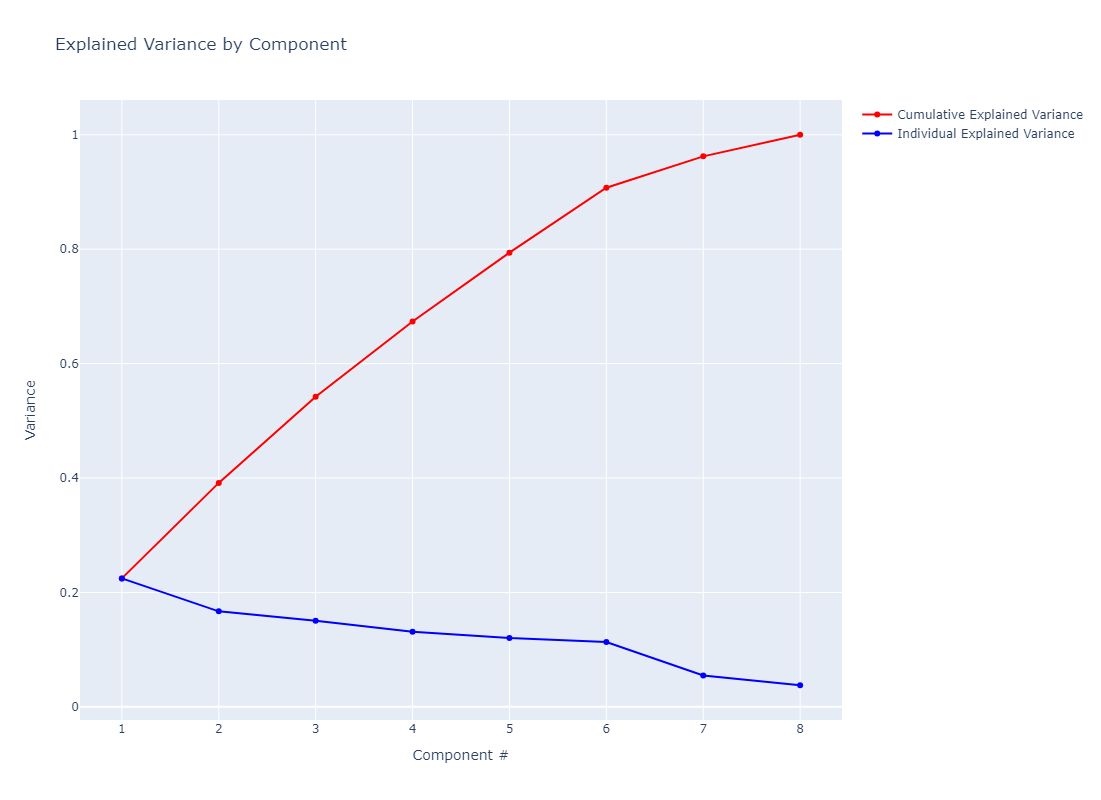

alt       lst      long       lat       sza  \
Principal Component 1  0.496425  0.455895  0.172773  0.269759  0.407352   
Principal Component 2  0.461618  0.397098  0.111121  0.424828  0.638824   
Principal Component 3  0.161532  0.436191  0.259328  0.611148  0.157673   
Principal Component 4  0.023847  0.224867  0.134122  0.224344  0.016893   
Principal Component 5  0.081255  0.053706  0.866838  0.028438  0.005325   
Principal Component 6  0.167962  0.145138  0.337177  0.188100  0.043352   
Principal Component 7  0.684760  0.000651  0.083629  0.208048  0.177682   
Principal Component 8  0.100500  0.608026  0.021706  0.493401  0.606089   

                       abundance  precision  mass_combined  
Principal Component 1   0.036870   0.525138       0.006009  
Principal Component 2   0.066548   0.145045       0.053226  
Principal Component 3   0.424137   0.304943       0.212482  
Principal Component 4   0.453855   0.279927       0.771958  
Principal Component 5   0.347075   0.246646       0.238688  
Principal Component 6   0.697714   0.196133       0.523928  
Principal Component 7   0.028287   0.651130       0.156474  
Principal Component 8   0.016379   0.092570       0.010353

In [449]:
L2_sample_data_processed_no_time = L2_sample_data_processed.drop(['t_unix', 'tid', 't_tid'], axis=1)

L2notime_pca, L2notime_pca_model = applyPCA(L2_sample_data_processed_no_time)
PCA_Scatter(L2_sample_data, L2notime_pca, 'no_time', 2)
PCA_Summary(L2notime_pca_model, L2_sample_data_processed_no_time.columns, 'L2notime')

In [387]:
L2_osion_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   t_utc         150000 non-null  datetime64[ns]
 1   t_unix        150000 non-null  float64       
 2   t_tid         150000 non-null  float64       
 3   tid           150000 non-null  int64         
 4   orbit         150000 non-null  int64         
 5   focusmode     150000 non-null  object        
 6   alt           150000 non-null  float64       
 7   lst           150000 non-null  float64       
 8   long          150000 non-null  float64       
 9   lat           150000 non-null  float64       
 10  sza           150000 non-null  float64       
 11  abundance     150000 non-null  float64       
 12  precision     150000 non-null  float64       
 13  quality       150000 non-null  object        
 14  t_sclk        150000 non-null  float64       
 15  ion_mass      150

In [439]:
def PCA_ScatterBy(DataFrame, pca, hue, filename):
    
    norm = Normalize(vmin=DataFrame[hue].min(), vmax=DataFrame[hue].max())  
    colormap = plt.get_cmap('plasma')

    def rgb_to_rgba(rgb):
        return f'rgba({int(rgb[0]*255)}, {int(rgb[1]*255)}, {int(rgb[2]*255)}, {rgb[3]})'
        
    rgba_colors = [rgb_to_rgba(colormap(norm(value))) for value in DataFrame[hue]]

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=pca[:, 0],
        y=pca[:, 1],
        mode='markers',
        marker={'size': 4, 'color': rgba_colors},
        showlegend=False))

    fig.add_trace(go.Scatter(
        x=[pca[:, 0].min(), pca[:, 0].max()],
        y=[pca[:, 1].min(), pca[:, 1].max()],
        mode='markers',
        marker=dict(
            size=0.1,
            color=[DataFrame[hue].min(), DataFrame[hue].max()], 
            colorscale='plasma', 
            colorbar=dict(thickness=10, title=hue), 
            showscale=True),
        hoverinfo='none',
        showlegend=False))
    
    fig.update_layout(
        title='2D PCA Scatter {} by {}'.format(filename, hue),
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        width=800,
        height=800)
    
    if plotly_display == True:
        fig.show()
    
    fig.write_html('PCA_2D_Scatter_{}_by{}.html'.format(filename, hue))

PCA_ScatterBy(L2_sample_data, L2time_pca, 'mass_combined', 'L2time')

In [455]:
L2_sample_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   t_unix         150000 non-null  float64
 1   t_tid          150000 non-null  float64
 2   tid            150000 non-null  int64  
 3   alt            150000 non-null  float64
 4   lst            150000 non-null  float64
 5   long           150000 non-null  float64
 6   lat            150000 non-null  float64
 7   sza            150000 non-null  float64
 8   abundance      150000 non-null  float64
 9   precision      150000 non-null  float64
 10  mass_combined  150000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 12.6 MB


In [443]:
PCA_ScatterBy(L2_sample_data, L2time_pca, 't_unix', 'L2time')
PCA_ScatterBy(L2_sample_data, L2time_pca, 'alt', 'L2time')
PCA_ScatterBy(L2_sample_data, L2time_pca, 'long', 'L2time')
PCA_ScatterBy(L2_sample_data, L2time_pca, 'lat', 'L2time')

In [451]:
PCA_ScatterBy(L2_sample_data, L2notime_pca, 'mass_combined', 'L2_no_time')
PCA_ScatterBy(L2_sample_data, L2notime_pca, 'alt', 'L2_no_time')
PCA_ScatterBy(L2_sample_data, L2notime_pca, 'long', 'L2_no_time')
PCA_ScatterBy(L2_sample_data, L2notime_pca, 'lat', 'L2_no_time')

In [457]:
L2_osion_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   t_utc         150000 non-null  datetime64[ns]
 1   t_unix        150000 non-null  float64       
 2   t_tid         150000 non-null  float64       
 3   tid           150000 non-null  int64         
 4   orbit         150000 non-null  int64         
 5   focusmode     150000 non-null  object        
 6   alt           150000 non-null  float64       
 7   lst           150000 non-null  float64       
 8   long          150000 non-null  float64       
 9   lat           150000 non-null  float64       
 10  sza           150000 non-null  float64       
 11  abundance     150000 non-null  float64       
 12  precision     150000 non-null  float64       
 13  quality       150000 non-null  object        
 14  t_sclk        150000 non-null  float64       
 15  ion_mass      150

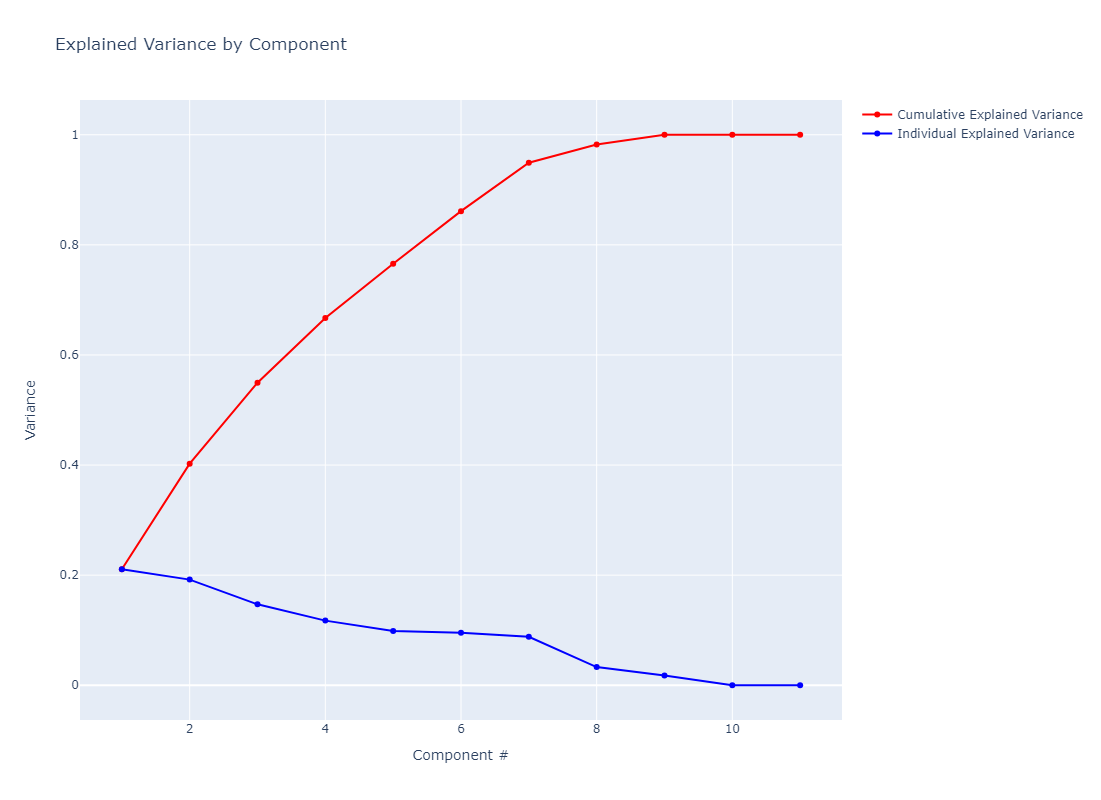

alt       lst      long       lat       sza  \
Principal Component 1   0.240114  0.064486  0.018556  0.087220  0.198001   
Principal Component 2   0.263121  0.090967  0.072808  0.474480  0.433199   
Principal Component 3   0.048174  0.778192  0.068729  0.274836  0.537817   
Principal Component 4   0.620554  0.012379  0.214280  0.412574  0.166199   
Principal Component 5   0.026127  0.058004  0.960323  0.087008  0.089156   
Principal Component 6   0.070056  0.019025  0.004060  0.025401  0.001804   
Principal Component 7   0.487348  0.021023  0.140328  0.345307  0.097351   
Principal Component 8   0.464032  0.301311  0.042261  0.618538  0.189004   
Principal Component 9   0.165170  0.535607  0.000814  0.107090  0.634912   
Principal Component 10  0.000201  0.000193  0.000024  0.000246  0.000287   
Principal Component 11  0.000000  0.000000  0.000000  0.000000  0.000000   

                        abundance  precision  ion_mass    cps_dt  sensitivity  \
Principal Component 1    0.626980   0.186252  0.100286  0.626997          0.0   
Principal Component 2    0.261080   0.053695  0.037301  0.261059          0.0   
Principal Component 3    0.071152   0.038670  0.003751  0.071051          0.0   
Principal Component 4    0.090654   0.195510  0.557989  0.090778          0.0   
Principal Component 5    0.003917   0.090921  0.222331  0.003940          0.0   
Principal Component 6    0.142634   0.900815  0.373140  0.142512          0.0   
Principal Component 7    0.070208   0.320867  0.697485  0.070208          0.0   
Principal Component 8    0.011917   0.003660  0.044887  0.012479          0.0   
Principal Component 9    0.004660   0.001968  0.004489  0.004999          0.0   
Principal Component 10   0.707107   0.000093  0.000007  0.707107          0.0   
Principal Component 11   0.000000   0.000000  0.000000  0.000000          1.0   

                        SC_potential  
Principal Component 1       0.245062  
Principal Component 2       0.603167  
Principal Component 3       0.104744  
Principal Component 4       0.070502  
Principal Component 5       0.022031  
Principal Component 6       0.052050  
Principal Component 7       0.119768  
Principal Component 8       0.521021  
Principal Component 9       0.520760  
Principal Component 10      0.000076  
Principal Component 11      0.000000

In [461]:
L2_osion_sdp_nt = L2_osion_sample_data.drop(['t_utc', 't_unix', 't_tid', 'tid', 'orbit', 'focusmode', 
                                             'quality', 't_sclk', 'cps_dt', 'sensitivity', 'year'], axis=1)
L2osion_notime_pca, L2osion_notime_pca_model = applyPCA(L2_osion_sdp_nt)
PCA_Scatter(L2_osion_sample_data, L2osion_notime_pca, 'osion_no_time', 2)
PCA_Summary(L2osion_notime_pca_model, L2_osion_sdp_nt.columns, 'L2osion_notime')

In [463]:
PCA_ScatterBy(L2_osion_sample_data, L2osion_notime_pca, 'abundance', 'L2osion_no_time')
PCA_ScatterBy(L2_osion_sample_data, L2osion_notime_pca, 'ion_mass', 'L2osion_no_time')
PCA_ScatterBy(L2_osion_sample_data, L2osion_notime_pca, 'SC_potential', 'L2osion_no_time')
PCA_ScatterBy(L2_osion_sample_data, L2osion_notime_pca, 'alt', 'L2osion_no_time')

In [465]:
L1b_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149718 entries, 0 to 149717
Data columns (total 37 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   t_utc           149718 non-null  datetime64[ns]
 1   t_unix          149718 non-null  float64       
 2   t_sclk_raw      149718 non-null  float64       
 3   t_sclk_cor      149718 non-null  float64       
 4   t_tid           149718 non-null  float64       
 5   tid             149718 non-null  int64         
 6   umkid           149718 non-null  int64         
 7   orbit           149718 non-null  int64         
 8   focus_mode      149718 non-null  object        
 9   multiplier      149718 non-null  int64         
 10  filament        149718 non-null  int64         
 11  temperature_s   149718 non-null  float64       
 12  mass            149718 non-null  float64       
 13  counts          149718 non-null  int64         
 14  cps_raw         149718 non-null  flo

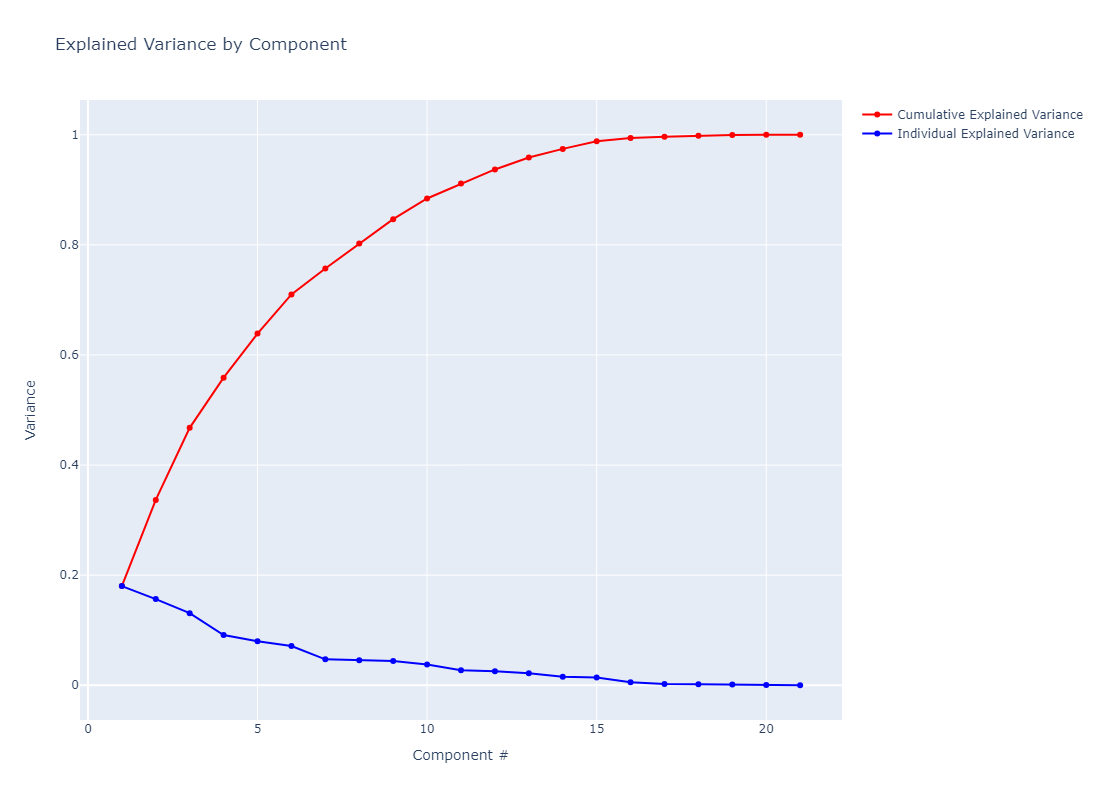

filament  temperature_s      mass    counts  \
Principal Component 1   0.019950       0.340084  0.048619  0.078504   
Principal Component 2   0.020907       0.156620  0.038420  0.022251   
Principal Component 3   0.087528       0.168495  0.030272  0.231851   
Principal Component 4   0.162502       0.003357  0.018222  0.611710   
Principal Component 5   0.069280       0.310184  0.061498  0.220054   
Principal Component 6   0.034790       0.034568  0.005088  0.041330   
Principal Component 7   0.288702       0.004323  0.944141  0.031743   
Principal Component 8   0.934356       0.061431  0.285912  0.085103   
Principal Component 9   0.029556       0.403123  0.125080  0.045474   
Principal Component 10  0.032964       0.040538  0.027200  0.005253   
Principal Component 11  0.003687       0.324559  0.036986  0.031397   
Principal Component 12  0.006211       0.011388  0.005144  0.005112   
Principal Component 13  0.003693       0.046668  0.007845  0.007597   
Principal Component 14  0.024553       0.143900  0.008541  0.018454   
Principal Component 15  0.004368       0.014128  0.000659  0.002583   
Principal Component 16  0.005822       0.031712  0.000452  0.001102   
Principal Component 17  0.000546       0.140801  0.000804  0.004733   
Principal Component 18  0.000843       0.641199  0.003311  0.039030   
Principal Component 19  0.005761       0.030879  0.005455  0.708468   
Principal Component 20  0.000353       0.067567  0.000564  0.004130   
Principal Component 21  0.000878       0.004451  0.000002  0.003595   

                        cps_dt_bkgd   alt_iau   vsc_iau      ram1  \
Principal Component 1      0.070446  0.016532  0.167478  0.012788   
Principal Component 2      0.020956  0.098408  0.040382  0.093015   
Principal Component 3      0.220999  0.531029  0.516157  0.420148   
Principal Component 4      0.615306  0.097292  0.186029  0.180837   
Principal Component 5      0.227685  0.101340  0.079073  0.117570   
Principal Component 6      0.043998  0.069029  0.054716  0.012525   
Principal Component 7      0.042104  0.036129  0.009509  0.026573   
Principal Component 8      0.092412  0.049294  0.065307  0.089764   
Principal Component 9      0.051129  0.301699  0.138647  0.162007   
Principal Component 10     0.004712  0.006089  0.006028  0.016018   
Principal Component 11     0.050114  0.021311  0.161508  0.704161   
Principal Component 12     0.008566  0.021959  0.019906  0.128671   
Principal Component 13     0.013414  0.031455  0.050767  0.168748   
Principal Component 14     0.042498  0.396383  0.300184  0.433011   
Principal Component 15     0.005952  0.046770  0.013563  0.044836   
Principal Component 16     0.005847  0.181801  0.107252  0.005077   
Principal Component 17     0.003635  0.019333  0.011417  0.025391   
Principal Component 18     0.042463  0.151826  0.189308  0.006704   
Principal Component 19     0.702823  0.008483  0.021173  0.014234   
Principal Component 20     0.002866  0.597093  0.675708  0.037384   
Principal Component 21     0.002360  0.120224  0.112165  0.003781   

                        ram2_rot_angle   sol_lon  ...       lst     x_iau  \
Principal Component 1         0.225101  0.168451  ...  0.094471  0.015439   
Principal Component 2         0.455101  0.315596  ...  0.107359  0.046044   
Principal Component 3         0.112810  0.056523  ...  0.023686  0.034240   
Principal Component 4         0.034146  0.010459  ...  0.237833  0.039991   
Principal Component 5         0.019390  0.007478  ...  0.668419  0.048912   
Principal Component 6         0.017275  0.017124  ...  0.026886  0.699329   
Principal Component 7         0.000607  0.008333  ...  0.034670  0.008278   
Principal Component 8         0.002552  0.021712  ...  0.001036  0.011259   
Principal Component 9         0.025268  0.020317  ...  0.164664  0.098366   
Principal Component 10        0.017839  0.673410  ...  0.003971  0.042112   
Principal Component 11        0.018504  0.028993  ...  0.015538  0.171550   
Principal Componen

In [477]:
L1b_sdp_nt = L1b_sample_data.drop(['t_utc', 't_unix', 't_sclk_raw', 't_sclk_cor', 't_tid', 'tid', 
                                   'umkid', 'orbit', 'focus_mode', 'multiplier', 'cps_raw', 'cps_raw_bkgd',
                                   'cps_dt', 'bkgd', 'quality', 'year'], axis=1)

L1b_nt_pca, L1b_nt_pca_model = applyPCA(L1b_sdp_nt)
PCA_Scatter(L1b_sample_data, L1b_nt_pca, 'L1b_no_time', 1)
PCA_Summary(L1b_nt_pca_model, L1b_sdp_nt.columns, 'L1b_no_time')

In [479]:
PCA_ScatterBy(L1b_sample_data, L1b_nt_pca, 'mass', 'L1b_no_time')
PCA_ScatterBy(L1b_sample_data, L1b_nt_pca, 'cps_dt_bkgd', 'L1b_no_time')
PCA_ScatterBy(L1b_sample_data, L1b_nt_pca, 'temperature_s', 'L1b_no_time')
PCA_ScatterBy(L1b_sample_data, L1b_nt_pca, 'vsc_iau', 'L1b_no_time')

In [491]:
L2_df[L2_df["year"] == '2018'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2237701 entries, 348207 to 2585907
Data columns (total 26 columns):
 #   Column           Dtype         
---  ------           -----         
 0   t_utc            datetime64[ns]
 1   t_unix           float64       
 2   t_sclk_cor       float64       
 3   t_tid            float64       
 4   tid              int64         
 5   orbit            int64         
 6   focusmode        object        
 7   alt              float64       
 8   lst              float64       
 9   long             float64       
 10  lat              float64       
 11  sza              float64       
 12  mass             float64       
 13  species          object        
 14  cps_dt_bkd       float64       
 15  abundance        float64       
 16  precision        float64       
 17  quality          object        
 18  t_sclk           float64       
 19  ion_mass         float64       
 20  cps_dt           float64       
 21  sensitivity      float64       

In [503]:
test_ids = L1b_df['tid'].unique()[:10]
L1b_df[L1b_df['tid'].isin(test_ids)]

t_utc        t_unix    t_sclk_raw    t_sclk_cor  \
0      2014-10-19 10:32:04  1.413715e+09  4.669867e+08  4.669867e+08   
1      2014-10-19 10:32:04  1.413715e+09  4.669867e+08  4.669867e+08   
2      2014-10-19 10:32:04  1.413715e+09  4.669867e+08  4.669867e+08   
3      2014-10-19 10:32:04  1.413715e+09  4.669867e+08  4.669867e+08   
4      2014-10-19 10:32:04  1.413715e+09  4.669867e+08  4.669867e+08   
...                    ...           ...           ...           ...   
421422 2014-10-21 04:28:19  1.413866e+09  4.671377e+08  4.671377e+08   
421423 2014-10-21 04:28:19  1.413866e+09  4.671377e+08  4.671377e+08   
421424 2014-10-21 04:28:19  1.413866e+09  4.671377e+08  4.671377e+08   
421425 2014-10-21 04:28:19  1.413866e+09  4.671377e+08  4.671377e+08   
421426 2014-10-21 04:28:19  1.413866e+09  4.671377e+08  4.671377e+08   

              t_tid    tid            umkid  orbit focus_mode  multiplier  \
0       9521.565798  14020  140200010802001    112      osion           2   
1       9521.595798  14020  140200010802001    112      osion           2   
2       9521.625798  14020  140200010802001    112      osion           2   
3       9521.655798  14020  140200010802001    112      osion           2   
4       9521.685798  14020  140200010802001    112      osion           2   
...             ...    ...              ...    ...        ...         ...   
421422  5999.793654  14035  140350013603429    122        csn           2   
421423  5999.823654  14035  140350013603429    122        csn           2   
421424  5999.853654  14035  140350013603429    122        csn           2   
421425  5999.883654  14035  140350013603429    122        csn           2   
421426  5999.913654  14035  140350013603429    122        csn           2   

        ...       y_iau        z_iau    vx_iau    vy_iau    vz_iau        lat  \
0       ...  434.561030  3777.862040 -1.304920 -3.507218 -0.901939  74.359215   
1       ...  434.455817  3777.834982 -1.304915 -3.507222 -0.902019  74.359207   
2       ...  434.350605  3777.807921 -1.304909 -3.507225 -0.902099  74.359199   
3       ...  434.245339  3777.780844 -1.304904 -3.507229 -0.902179  74.359191   
4       ...  434.140126  3777.753779 -1.304898 -3.507232 -0.902259  74.359183   
...     ...         ...          ...       ...       ...       ...        ...   
421422  ... -648.081342   231.623960  1.243729  0.567810 -3.623140   3.427325   
421423  ... -648.064308   231.515270  1.243650  0.567819 -3.623145   3.425690   
421424  ... -648.047274   231.406580  1.243570  0.567827 -3.623150   3.424056   
421425  ... -648.030240   231.297890  1.243490  0.567836 -3.623155   3.422421   
421426  ... -648.013206   231.189199  1.243410  0.567844 -3.623160   3.420787   

              long        sza  quality  year  
0       156.002261  92.123330      TSC  2014  
1       156.008268  92.122701      TSC  2014  
2       156.014276  92.121449      TSC  2014  
3       156.020287  92.120819      TSC  2014  
4       156.026295  92.119568      TSC  2014  
...            ...        ...      ...   ...  
421422   -9.547417  54.365916      TSC  2014  
421423   -9.547080  54.365310      TSC  2014  
421424   -9.546743  54.364703      TSC  2014  
421425   -9.546406  54.364097      TSC  2014  
421426   -9.546069  54.363490      TSC  2014  

[421427 rows x 37 columns]

In [505]:
L2_df[L2_df['tid'].isin(test_ids)]

t_utc        t_unix    t_sclk_cor        t_tid    tid  \
0      2014-10-18 16:03:49  1.413648e+09  4.669202e+08  8814.575810  14016   
1      2014-10-18 16:03:51  1.413648e+09  4.669202e+08  8816.575810  14016   
2      2014-10-18 16:03:53  1.413648e+09  4.669202e+08  8818.575810  14016   
3      2014-10-18 16:03:55  1.413648e+09  4.669202e+08  8820.575810  14016   
4      2014-10-18 16:03:57  1.413648e+09  4.669202e+08  8822.575810  14016   
...                    ...           ...           ...          ...    ...   
348202 2014-10-20 23:31:57  1.413848e+09           NaN  4842.243245  14033   
348203 2014-10-20 23:31:59  1.413848e+09           NaN  4844.243245  14033   
348204 2014-10-20 23:32:02  1.413848e+09           NaN  4847.243245  14033   
348205 2014-10-20 23:32:05  1.413848e+09           NaN  4850.243245  14033   
348206 2014-10-20 23:32:07  1.413848e+09           NaN  4852.243245  14033   

        orbit focusmode       alt        lst      long  ...  precision  \
0         108       csn  559.9087   9.711944  66.29287  ...   0.000000   
1         108       csn  558.0256   9.739167  66.69056  ...   0.000000   
2         108       csn  556.1461   9.766111  67.08859  ...   0.000000   
3         108       csn  554.2701   9.793333  67.48693  ...   0.000000   
4         108       csn  552.3976   9.820278  67.88554  ...   0.000000   
...       ...       ...       ...        ...       ...  ...        ...   
348202    121     osion  363.1879  12.088890  12.34954  ...   0.164311   
348203    121     osion  361.8003  12.108060  12.62858  ...   0.164311   
348204    121     osion  359.7276  12.136670  13.04373  ...   0.164311   
348205    121     osion  357.6657  12.164720  13.45478  ...   0.164311   
348206    121     osion  356.2971  12.183610  13.72655  ...   0.164311   

        quality        t_sclk ion_mass     cps_dt  sensitivity  SC_potential  \
0            IU           NaN      NaN        NaN          NaN           NaN   
1            IU           NaN      NaN        NaN          NaN           NaN   
2            IU           NaN      NaN        NaN          NaN           NaN   
3            IU           NaN      NaN        NaN          NaN           NaN   
4            IU           NaN      NaN        NaN          NaN           NaN   
...         ...           ...      ...        ...          ...           ...   
348202      SCP  4.671199e+08     87.0  37.039747        550.0     -0.524682   
348203      SCP  4.671199e+08     87.0  37.039747        550.0     -0.560059   
348204      SCP  4.671199e+08     87.0  37.039747        550.0     -0.605132   
348205      SCP  4.671199e+08     87.0  37.039747        550.0     -0.491099   
348206      SCP  4.671199e+08     87.0  37.039747        550.0     -0.468523   

       t_sclk_combined  mass_combined  year  
0         4.669202e+08           40.0  2014  
1         4.669202e+08           40.0  2014  
2         4.669202e+08           40.0  2014  
3         4.669202e+08           40.0  2014  
4         4.669202e+08           40.0  2014  
...                ...            ...   ...  
348202    4.671199e+08           87.0  2014  
348203    4.671199e+08           87.0  2014  
348204    4.671199e+08           87.0  2014  
348205    4.671199e+08           87.0  2014  
348206    4.671199e+08           87.0  2014  

[182653 rows x 26 columns]

In [507]:
L2_df[L2_df['tid'] == 14016]['focusmode'].unique()

array(['csn', 'osion'], dtype=object)

In [ ]:
L2_df[L2_df['tid'] == 14016]['focusmode'].unique()